In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix


In [2]:
data = pd.read_csv('neo.csv')

In [3]:
X = data.drop(columns=['hazardous'])
y = data['hazardous']

# train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Results:
                      Accuracy    Recall  F1-score  Precision
Logistic Regression  0.901750  0.072870  0.127139   0.498084
Random Forest        0.917988  0.420404  0.501672   0.621891
Decision Tree        0.892668  0.448430  0.450704   0.453001
XGBoost              0.913144  0.225897  0.338087   0.671667


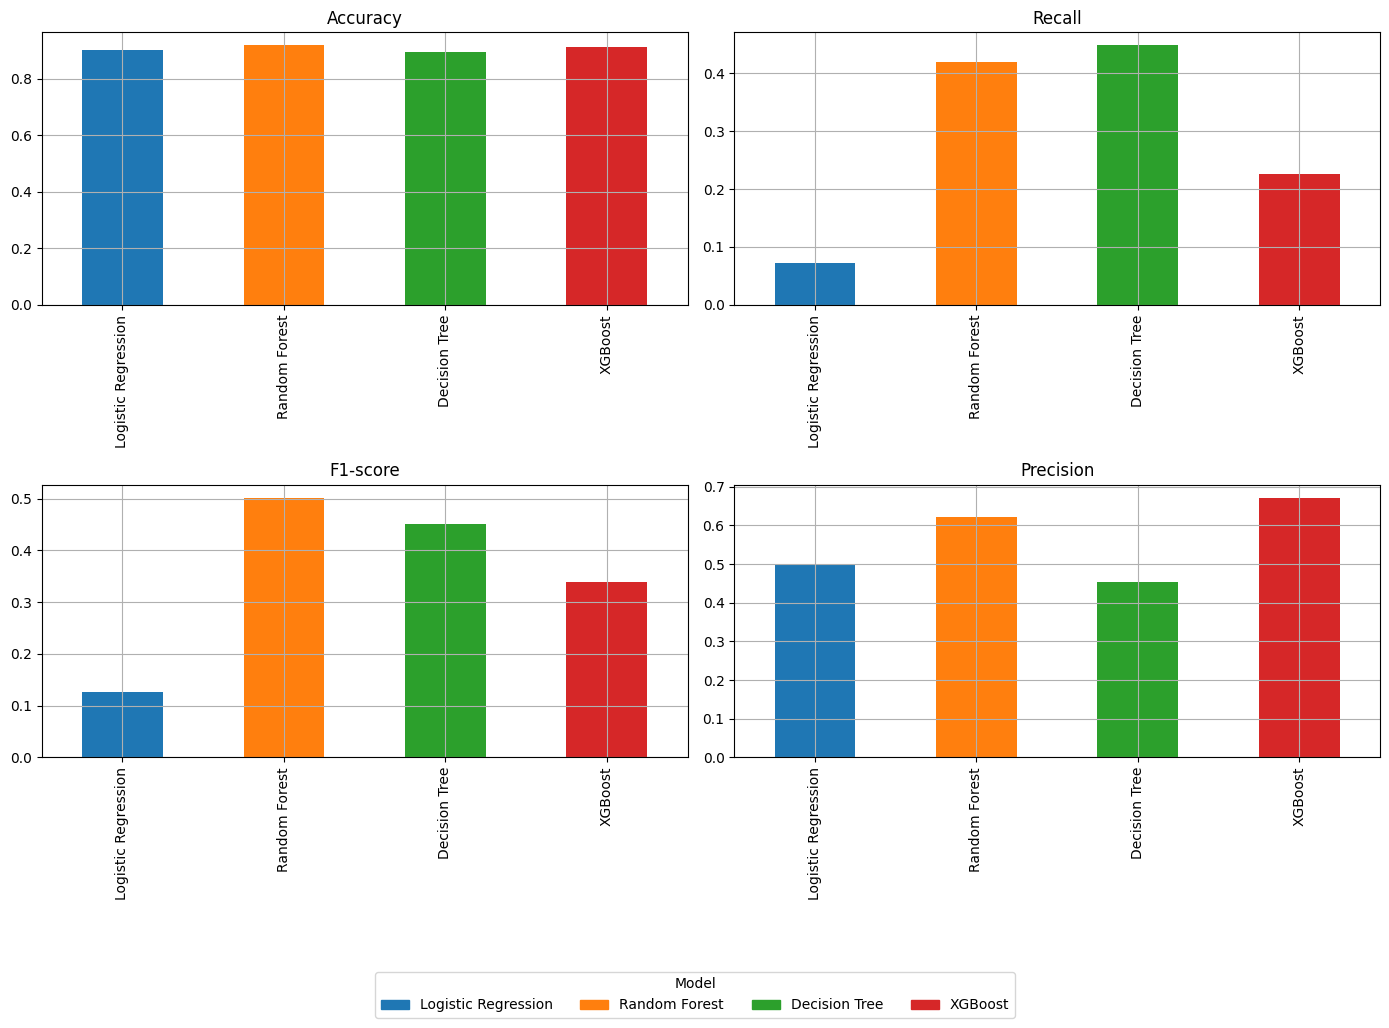

In [24]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

numeric_features = X_train.select_dtypes(include=['float64']).columns.tolist()
categorical_features = ['orbiting_body']

# Tnumeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# resuilts
results = {}

for model_name, model in models.items():
    # model pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # model train
    pipe.fit(X_train, y_train)
    
    # pred test
    y_pred = pipe.predict(X_test)
    
    # Obliczenie metryk
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Recall': recall,
        'F1-score': f1,
        'Precision': precision
    }

# results
results_df = pd.DataFrame(results).T
print("Results:\n", results_df)

# models colours
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
model_colors = {model: color for model, color in zip(results_df.index, colors)}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for metric, ax in zip(results_df.columns, axes.flatten()):
    bars = results_df[metric].plot(kind='bar', ax=ax, color=[model_colors[idx] for idx in results_df.index])
    ax.set_title(metric)
    ax.grid(True)

    #legend
handles = [plt.Rectangle((0,0),1,1, color=model_colors[idx]) for idx in results_df.index]
fig.legend(handles, results_df.index, title="Model", loc='upper center', ncol=len(models), bbox_to_anchor=(0.5, -0.02))


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
